In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
#Seasonality for Analysis
t_season='MJJAS'
t_months=[5,6,7,8,9]
#Time period for analysis
start_year = '1970-01-01'
end_year = '2010-12-01'
#Spatial domain for analysis
ext_e = -100
ext_w = -115
ext_n = 50
ext_s = 42

#Point locations for plotting
ggw_lat,ggw_lon = 48.18, -106.635
ftp_lat, ftp_lon = 48.3077, -105.1019

#Temp data
data_dir = '/Users/gbromley/data/CRU/'
temp_file = 'tmp/cru_ts3.24.1901.2015.tmp.dat.nc'

nc_temp = xr.open_dataset(data_dir+temp_file)
t2m = nc_temp['tmp']

In [3]:
#vapor pressure data
vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
nc_vap = xr.open_dataset(data_dir+vap_file)



vap = nc_vap['vap']
#Calculate mixing ratio
mr = ((0.622*(vap))/(1000.-vap))
#calculate specific humidty
spec_hum = mr/(mr+1)



#mr.to_netcdf('specific_humidity_test.nc')

In [ ]:
t2m = spec_hum

In [ ]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1981-01-01','2010-12-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [ ]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [ ]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
for i in np.arange(0,len(t2m['lat'])):
    for j in np.arange(0,len(t2m['lon'])):
        series = t2m_months_avg[:,i,j]
        anom = series-t2m_clim_months_avg[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope*10
        pvalues[i,j]=p_value
        #print(i)

In [ ]:
spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_specific_humidity_'+t_season+'_'+'1970'+'.nc')

In [4]:
calc_spatial = xr.open_dataarray(data_dir+'CRU_specific_humidity_MJJAS_1970.nc')

In [5]:
spatial_trend = calc_spatial

In [6]:
spatial_trend = spatial_trend * 1000.


In [ ]:
spatial_trend.max()

In [ ]:
anom_series = t2m_months_avg - t2m_clim_months_avg

In [ ]:
test_series = anom_series.sel(lat=48.75)
test_series = test_series.sel(lon=-106.75)
anom_series = test_series
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom_series)),anom_series.values)
line = slope*np.arange(0,len(anom_series.values))+intercept
anom_series = anom_series*1000.
anom_series = anom_series.to_pandas()

In [ ]:
anom_series.index

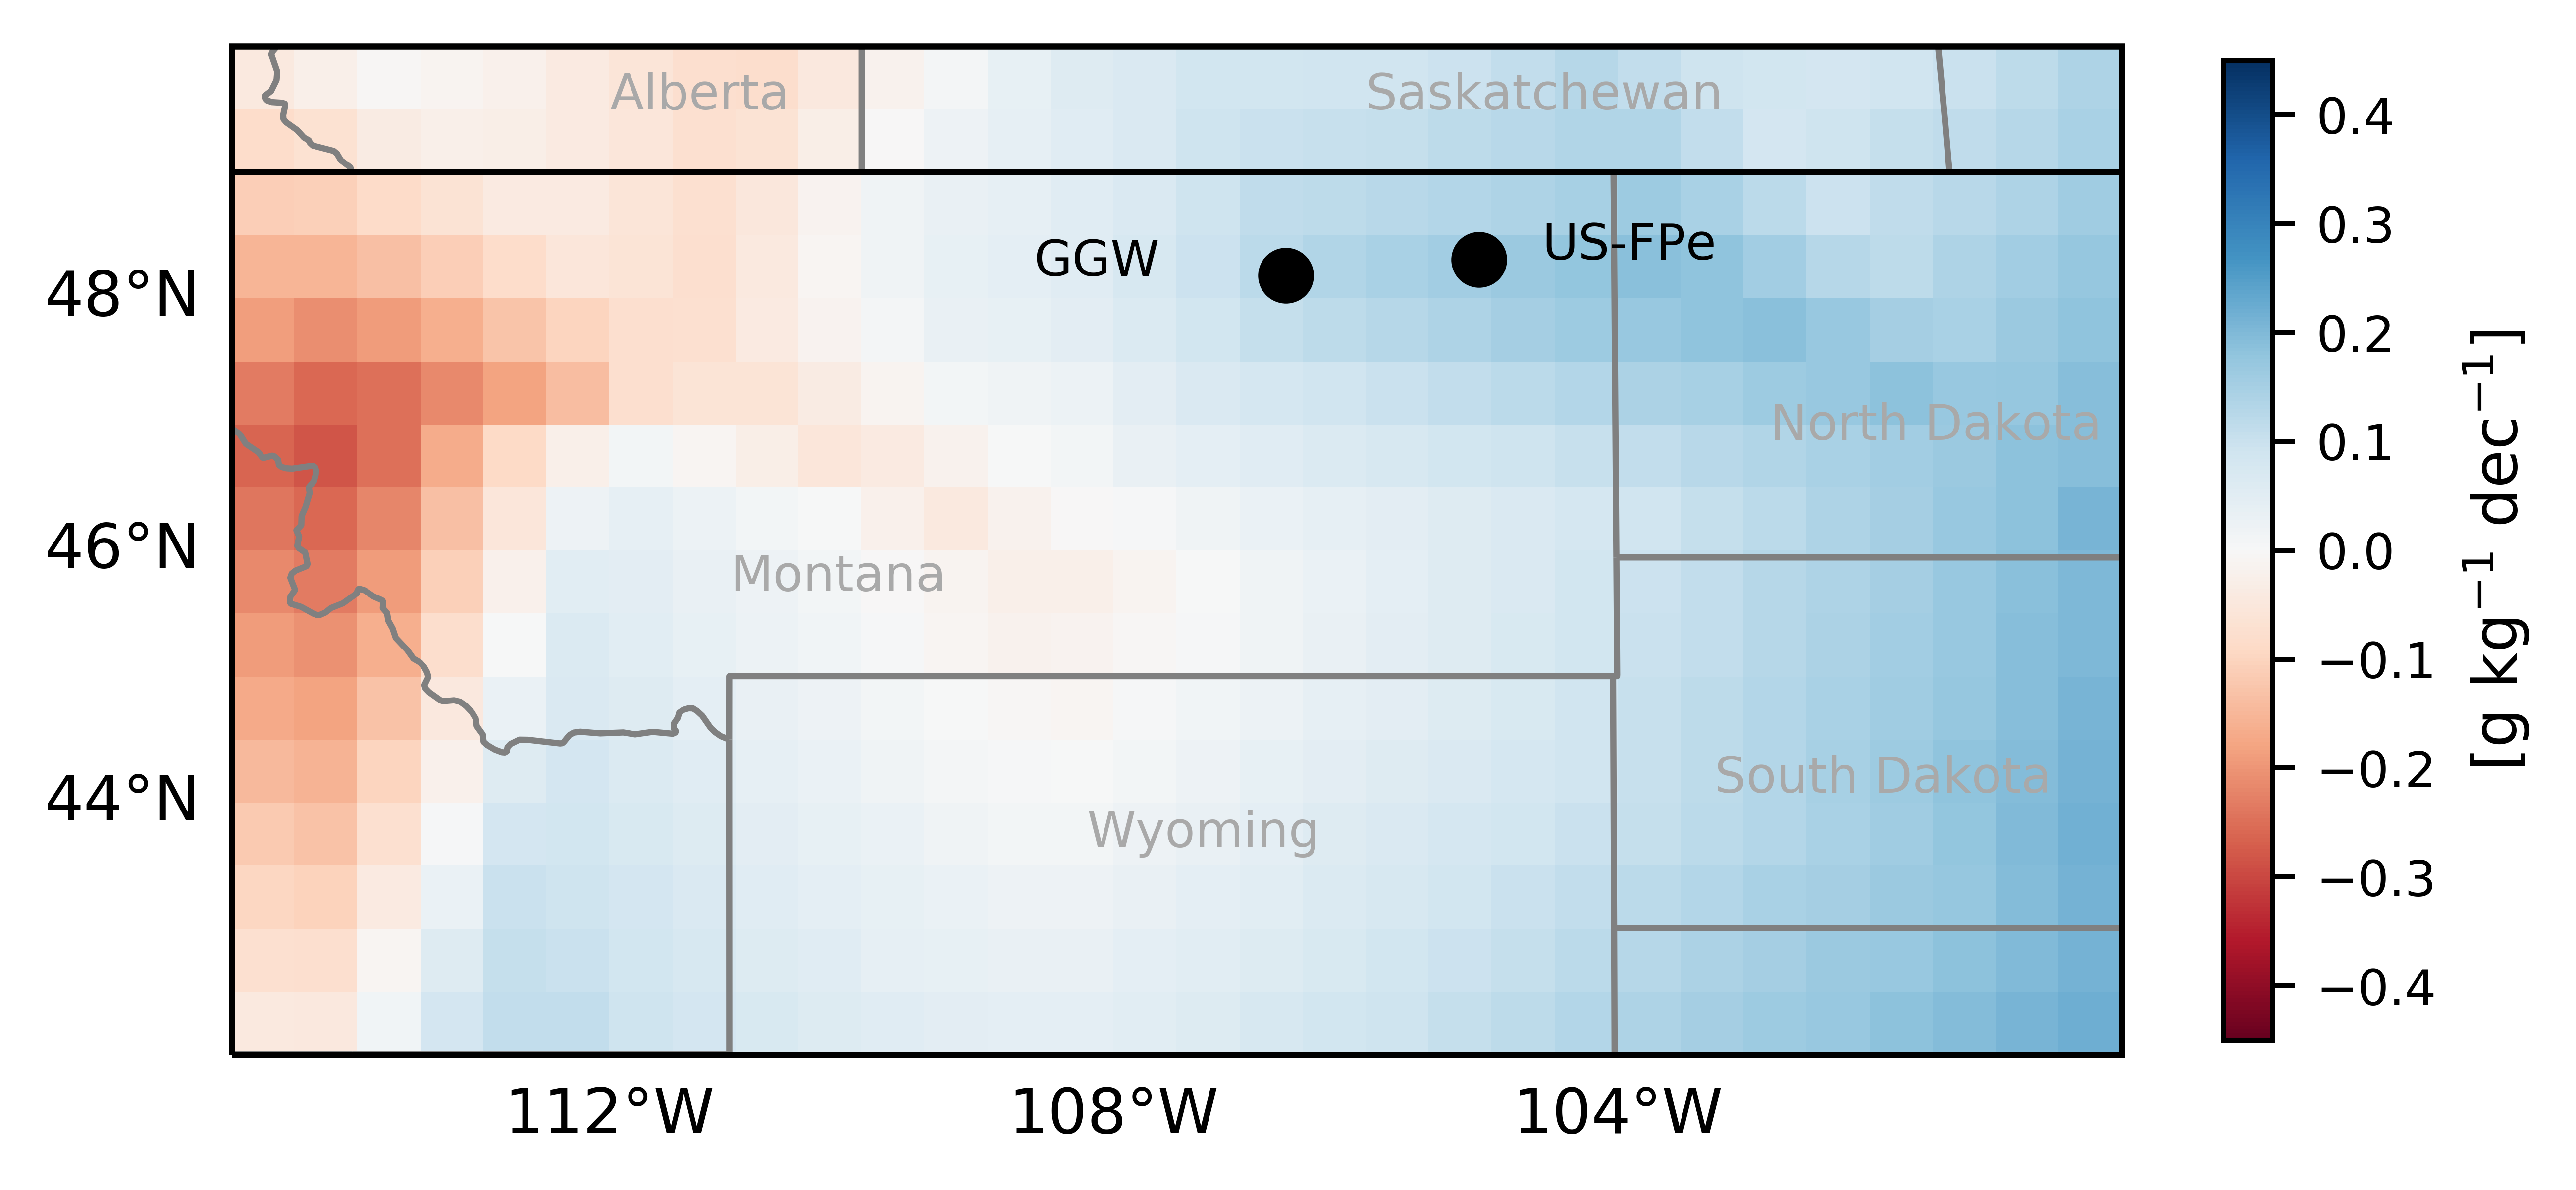

'\nfig2 = plt.figure(2,figsize=(13,7), dpi=1200.0, edgecolor=\'black\')\nax2 = plt.subplot(211, facecolor=\'white\')\n#plt.rc(\'grid\', linestyle="-", color=\'gray\')\n#plt.grid(True)\nanom_series.plot(color=\'blue\')\nanom_series.rolling(window=5).mean().plot( color=\'red\')\nax2.plot(anom_series.index.values,line, color=\'black\')\nbase = np.zeros(len(anom_series.values))\nplt.plot(anom_series.index.values,base,color=\'black\')\n#ax2.set_title(\'Temp at GGW\'+start_year[0:4]+\'-\'+end_year[0:4]+\' \'+t_season)\nax2.set_xlabel(\'Year\')\nax2.set_ylabel(\'Specific Humidity Anomaly [g $\\mathregular{kg^{-1}}$]\')\n#plt.text(0.1, 0.9,\'b\', ha=\'center\', va=\'center\', backgroundcolor=\'lightgray\')\nanchored_text = AnchoredText("b", loc=2)\nax2.add_artist(anchored_text)\nfig2.savefig(\'CRU_sp_hum_moisture_paper\'+start_year[0:4]+\'-\'+end_year[0:4]+\' \'+t_season+\' TS.png\', bbox_inches=\'tight\')\nplt.show()\n'

In [27]:
fig = plt.figure(1,figsize=(13,7), dpi=900.0)
#projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
projection = ccrs.PlateCarree(central_longitude=-105.0, globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-0.45, vmax=0.45, cmap='RdBu',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())

ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='gray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
#ax1.gridlines(draw_labels=True)
#ax1.set_yticks([44,46,48], crs=ccrs.PlateCarree())
#ax1.set_xticks([-112,-108,-104], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-112,-108,-104])
gl.ylocator = mticker.FixedLocator([42,44,46,48,50])
gl.xlines=False
gl.ylines=False
#ax1.set_yticks([44,46,48], crs=ccrs.PlateCarree())
#ax1.set_xticks([-112,-108,-104], crs=ccrs.PlateCarree())
#ax1.gridlines()
plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#MT
plt.text(-111.0429, 45.6770, 'Montana', transform=ccrs.PlateCarree(), size=8, axes=ax1,color='darkgrey')

#WY
plt.text(-108.2120, 43.6461,  'Wyoming', transform=ccrs.PlateCarree(), size=8, axes=ax1,color='darkgrey')
#SD

plt.text(-103.2310, 44.0805,  'South Dakota', transform=ccrs.PlateCarree(), size=8,axes=ax1, color='darkgrey')
#ND
plt.text(-102.7896, 46.8792,  'North Dakota', transform=ccrs.PlateCarree(), size=8, axes=ax1, color='darkgrey')

#Alberta
plt.text(-112, 49.5,  'Alberta', transform=ccrs.PlateCarree(), size=8, axes=ax1, color='darkgrey')

#Saskatchewan
plt.text(-106, 49.5,  'Saskatchewan', transform=ccrs.PlateCarree(), size=8, axes=ax1, color='darkgrey')

ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu',fraction=0.024)
cb.set_label(r'[g $\mathregular{kg^{-1}}$ $\mathregular{dec^{-1}}$]',fontsize=10)
cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
#anchored_text = AnchoredText("a", loc=2)
#ax1.add_artist(anchored_text)

plt.savefig('JHM_sh'+t_season+'_1970.png',bbox_inches='tight', dpi=600)
plt.show()
'''
fig2 = plt.figure(2,figsize=(13,7), dpi=1200.0, edgecolor='black')
ax2 = plt.subplot(211, facecolor='white')
#plt.rc('grid', linestyle="-", color='gray')
#plt.grid(True)
anom_series.plot(color='blue')
anom_series.rolling(window=5).mean().plot( color='red')
ax2.plot(anom_series.index.values,line, color='black')
base = np.zeros(len(anom_series.values))
plt.plot(anom_series.index.values,base,color='black')
#ax2.set_title('Temp at GGW'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season)
ax2.set_xlabel('Year')
ax2.set_ylabel('Specific Humidity Anomaly [g $\mathregular{kg^{-1}}$]')
#plt.text(0.1, 0.9,'b', ha='center', va='center', backgroundcolor='lightgray')
anchored_text = AnchoredText("b", loc=2)
ax2.add_artist(anchored_text)
fig2.savefig('CRU_sp_hum_moisture_paper'+start_year[0:4]+'-'+end_year[0:4]+' '+t_season+' TS.png', bbox_inches='tight')
plt.show()
'''

In [24]:
fig.canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpeg': 'Joint Photographic Experts Group',
 'jpg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format'}

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()